In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import Lasso, ElasticNet, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest, AdaBoostRegressor

from sklearn import metrics
from sklearn.metrics import r2_score
import sklearn.preprocessing

import xgboost as xgb
from xgboost import XGBRegressor

from scipy.stats import boxcox
import time

import warnings
warnings.filterwarnings("ignore")

import os

#Data Preprocessing
from sklearn.model_selection import train_test_split

#Feature Selectors
from sklearn.feature_selection import chi2

#Models
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

#Model Evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [2]:
#Two functions that create dummy variables
#Just needs the DataFrame to be encoded
def dummy(data):
    data = pd.get_dummies(data)
    return data

#All missing values for categorical features will be labelled as "None"
def cat_null_values(dat,feat):
    dat.loc[dat[feat].isnull(), feat] = "None"

#Replace numeric null values by their mean (or zero)
def numeric_null_values(dat,feat):
    dat.loc[dat[feat].isnull(),feat] = np.mean(dat[feat])
    #dat.loc[dat[feat].isnull(),feat] = 0

#Cross validation score for a model for selected features
def cross_val(model,data,features):
    scores = (cross_val_score(model,data[features],data["recovered"],cv=5,n_jobs=1)).mean()
    return scores

#Scoring method for this competition
#true = actual "SalePrice", pred = predicted "SalePrice" (using a model)
def RMSE_log(true,pred):
    RMSE = metrics.mean_squared_error(np.log(true),np.log(pred))**0.5
    return RMSE

#Optimise parameters with GridSearchCV
#data = données à utiliser, feat = features, target = SalePrice, params = dict of parameters to pass to GridSearch
#model = (Lasso, Elastic Net, etc), X_valid = data for prediction and submission to Kaggle
def GridSearch(data,feat,target,params,model,X_valid):
    X = data[feat]
    y = data[target]
    mod = model()
    mod_CV = GridSearchCV(estimator=mod, param_grid=params,cv=10,n_jobs=2,scoring='r2')
    mod_CV.fit(X,y)
    print("Best parameters :",mod_CV.best_params_)
    print("Best R2 score :",mod_CV.best_score_)
    pred = mod_CV.predict(X_valid)
    return mod_CV, pred

#data_valid=data for prediction and submission to Kaggle; pred = "SalePrice" predicted by the model
def writePredFile(data_valid, pred, fileName):
    answer = pd.DataFrame()
    answer["Id"] = (data_valid.Id).astype(int)
    answer["SalePrice"] = pred
    answer.to_csv(fileName,index=False)
    
#Constructing an ensemble regressor (simply calculates the mean)
def EnsembleRegressor(regressors,X_Validation):
    EnsemblePred = pd.DataFrame()
    for reg in regressors:
        colname = str(reg)[:4]
        EnsemblePred[colname] = reg.predict(X_Validation)
    EnsemblePred["Ensemble"] = EnsemblePred.apply(lambda x: np.mean(x), axis=1) #Mean scores better than median
    return EnsemblePred

def OptimiseParameters(model,X,y,parameters,n_jobs=1, scoring='r2', error_score=0):
    t_init = time.time()
    modelCV = model()
    CV_model = GridSearchCV(estimator=modelCV,param_grid=parameters,cv=10,n_jobs=n_jobs,scoring=scoring)
    CV_model.fit(X,y)
    t_final = time.time()
    bparams = CV_model.best_params_
    bscore = CV_model.best_score_
    print("Execution time: {}\n".format(t_final-t_init))
    print("Best parameters: {}\n ".format(CV_model.best_params_))
    print("Best R2 score: {}\n".format(CV_model.best_score_))
    print("Best estimator: {}\n".format(CV_model.best_estimator_))
    return CV_model, bscore,bparams  #returns the model, best score and best parameters

def plot_cat(data, x_axis, y_axis, hue):
    plt.figure()    
    sns.barplot(x=x_axis, y=y_axis, hue=hue, data=data)
    sns.set_context("notebook", font_scale=1.6)
    plt.legend(loc="upper right", fontsize="medium") 

In [3]:
data = pd.read_csv("daily.csv")
data2 = pd.read_csv("current.csv")

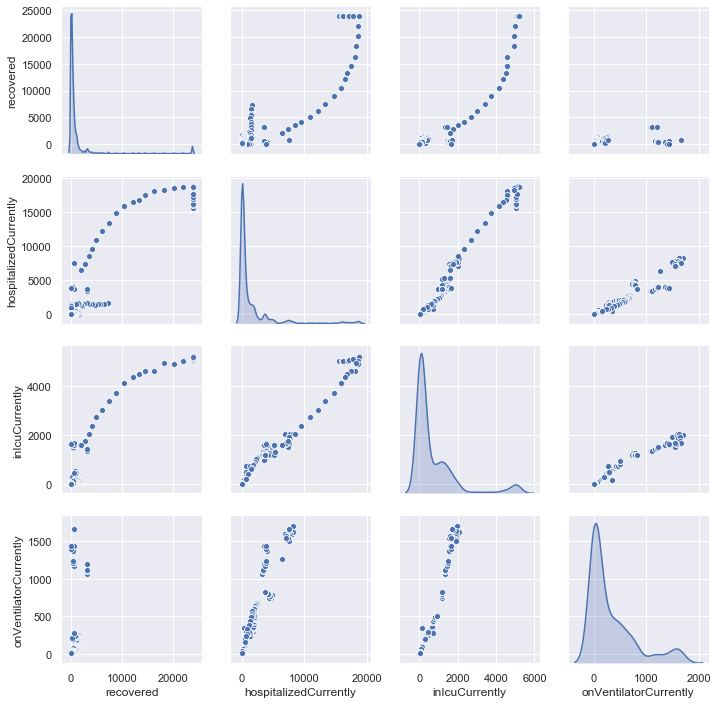

In [4]:
sns.set()
cols = ['recovered', "hospitalizedCurrently","inIcuCurrently", "onVentilatorCurrently"]
sns.pairplot(data[cols], size = 2.5, diag_kind="kde", dropna=True,diag_kws=dict(shade=True))
plt.show()

In [5]:
for dat in [data]:
    #Let's fetch the names of all numeric features
    colnames_num = (dat.select_dtypes(exclude=[object])).columns
    #Numerical features
    for c_ in colnames_num:
        numeric_null_values(dat,c_)

In [6]:
#Liste of features to be "boxcox" tranformed (none in this example, but improves score when carefully selected)
boxcox_features = [] #Keep the list of transformed features for later use
for bf in boxcox_features:
    for dat in [data]:
        colname = str(bf)
        box = boxcox(dat[colname])
        dat[colname] = box[0]

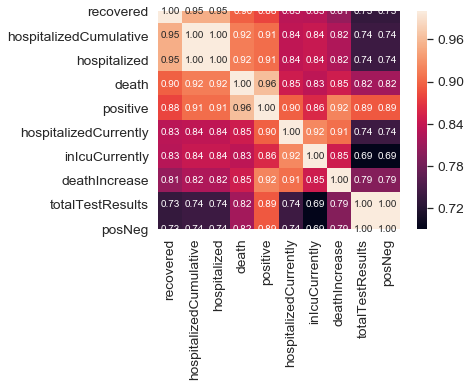

In [7]:
#recovered correlation matrix
corrmat = data.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'recovered')['recovered'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
for dat in [data]:
    #Names of categorical features
    colnames_cat = (dat.select_dtypes(['object'])).columns
    #For categorical features, I'll replace any null value by "None"
    for c_ in colnames_cat:
        cat_null_values(dat,c_)
#Let's create dummy data set
data = dummy(data)

In [10]:
features = list(data.columns)
features.remove("recovered")
target = "recovered"

In [11]:
train,test = train_test_split(data, test_size=0.2)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [27]:
#ADABOOST REGRESSOR
AdaBoost_model = AdaBoostRegressor(n_estimators=1000, learning_rate=0.7, loss="square")
AdaBoost_model.fit(X_train,y_train)
AdaBoost_pred_test = AdaBoost_model.predict(X_test)
print("***ADABOOST REGRESSOR***\nRMSE for test set : ",RMSE_log(y_test,AdaBoost_pred_test))
print("R2 pour le test set : {}".format(r2_score(y_test,AdaBoost_pred_test)))
print("Crossval score : {}\n".format(cross_val(AdaBoost_model,data,features)))

***ADABOOST REGRESSOR***
RMSE for test set :  1.002981856578307
R2 pour le test set : 0.9360644629089436
Crossval score : -2.834256365712661e+28



In [28]:
#GBOOST REGRESSOR
GBoost_model = GradientBoostingRegressor(loss="huber",
                                         learning_rate=0.4,
                                         n_estimators=5000,
                                        max_depth=6,
                                        alpha=0.2)
GBoost_model.fit(X_train,y_train)
GBoost_pred_test = GBoost_model.predict(X_test)
print("***GRADIENT BOOSTING REGRESSOR*** \nRMSE for test set : ",RMSE_log(y_test,GBoost_pred_test))
print("R2 for test set : {}".format(r2_score(y_test,GBoost_pred_test)))
print("Crossval score : {}\n".format(cross_val(GBoost_model,data,features)))

***GRADIENT BOOSTING REGRESSOR*** 
RMSE for test set :  1.105239583860341
R2 for test set : -1.6206617203806672e-07
Crossval score : 0.18537386828134145



In [29]:
lasso_model = Lasso(alpha=150,max_iter=5000)
lasso_model.fit(X_train,y_train)
lasso_pred = lasso_model.fit(X_test,y_test)
lasso_pred = lasso_model.predict(X_test)
print("***LASSO REGRESSOR***: {}".format(RMSE_log(pred=lasso_pred,true=y_test)))
print("LASSO has eliminated {0} features and kept {1}".format((lasso_model.coef_ == 0).sum(),(lasso_model.coef_ != 0).sum()))
print("Crossval score : {}".format(cross_val(lasso_model,data,features)))

***LASSO REGRESSOR***: 0.9123514493822743
LASSO has eliminated 2788 features and kept 20
Crossval score : -1.1979532359824568e+29
